This notebook is to evaluate galaxies which have low SNR but which nevertheless have sufficiently high log(SFR), log(Mstar), and log(sSFR) to meet out Virgo sample cuts.

In [276]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from photutils.aperture import CircularAperture
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.table import Table
import os
from astropy.io import fits
import glob
from scipy.stats import binned_statistic_2d
homedir=os.getenv("HOME")

In [178]:
#image path location
im_path = homedir+'/Desktop/zinput_im/'
#image name format: unwise-VFIDxxxx-w3-img-m.fits
#(I am using FITS files from ~3 years ago, for consistency.)

In [ ]:
#this function replicates (as closely as possible) the SNR routine I created ~3 years ago.
#NOTE: DO NOT USE! THE INPUT IMAGES ARE FOR V1 VFIDs, NOT V2 VFIDs!
def surface_brightness(galaxy_table,im_path):
    surf15 = np.zeros(len(galaxy_table),dtype=float)
    surf30 = np.zeros(len(galaxy_table),dtype=float)
    objnames = galaxy_table['VFID']
    for n in galaxy_table:
        im = glob.glob(f'{im_path}unwise-{n['VFID']}*')[0]
        #open the image...
        hdu_im=fits.open(im)[0]   
        #WCS header information
        wcs_w3 = WCS(hdu_im) 
        img_len = len(hdu_im.data)
        position = (int(img_len/2.),int(img_len/2.))   #(x,y) pixel coords
        len_arcsec = np.abs(hdu_im.header['NAXIS1']*hdu_im.header['CD1_1'])*3600.
        arcsec_per_pixel = len_arcsec/hdu_im.header['NAXIS1']     #should be 2.75"/px for W1, W3
        #15" and 30" apertures
        radius_15 = 15/arcsec_per_pixel
        radius_30 = radius_15*2
        #note --> the masks act as 'cookie cutters,' isolating the image region within the given radius
        aper15 = CircularAperture(position,radius_15)
        mask15 = aper15.to_mask(method='center')   #'cookie cutter'
        aper30 = CircularAperture(position,radius_30)
        mask30 = aper30.to_mask(method='center')
        data15_im = mask15.multiply(hdu_im.data)
        data30_im = mask30.multiply(hdu_im.data)
        data15_im = data15_im[data15_im!=0.]
        data30_im = data30_im[data30_im!=0.]
        signal15 = np.sqrt(np.sum(data15_im**2))
        signal30 = np.sqrt(np.sum(data30_im**2))
        surf15[galaxy_table['VFID']==n['VFID']] = round(signal15/(np.pi*radius_15**2),1)
        surf30[galaxy_table['VFID']==n['VFID']] = round(signal30/(np.pi*radius_30**2),1)
    return surf15, surf30

In [320]:
vf=Table.read(homedir+'/Desktop/galfit_files/VF_WISESIZE_v2.fits')
magphys = Table.read(homedir+'/Desktop/galfit_files/vf-altphot.fits')
phot = Table.read(homedir+'/Desktop/galfit_files//vf_v2_legacy_ephot.fits')   #also has a phot success flag!
logsfr = magphys['combined_logSFR_med']
logmass = magphys['combined_logMstar_med']

In [321]:
err_flag = (magphys['magphys_flag']) &  (magphys['combined_logSFR_med']!=0.)
sample_flag = (vf['massflag']) & (vf['SFRflag']) & (vf['sSFR_flag'])
qual_flag = err_flag & sample_flag

In [322]:
snr15_flag, snr30_flag = vf['snr15_flag'], vf['snr30_flag']

In [323]:
vf = vf[qual_flag]
logmass = logmass[qual_flag]
logsfr = logsfr[qual_flag]
snr15 = vf['snr15']
snr30 = vf['snr30']
snr15_flag = snr15_flag[qual_flag]
snr30_flag = snr30_flag[qual_flag]
phot = phot[qual_flag]

In [ ]:
#outputs row-matched surface brightness columns for the 15" and 30" apertures.
#NOTE: DO NOT USE! THE INPUT IMAGES ARE FOR V1 VFIDs, NOT V2 VFIDs!
surf15,surf30 = surface_brightness(vf,im_path)

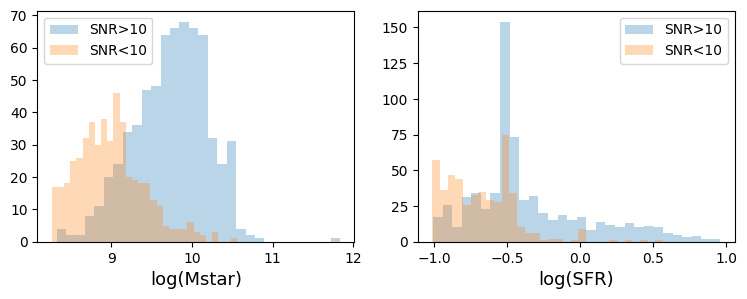

In [179]:
plt.subplots(1,2,figsize=(9,3))
plt.subplot(121)
plt.hist(logmass[snr15_flag | snr30_flag],bins=30,label='SNR>10',alpha=0.3)
plt.hist(logmass[~snr15_flag & ~snr30_flag],bins=30,label='SNR<10',alpha=0.3)
plt.legend(loc='upper left')
plt.xlabel('log(Mstar)',fontsize=13)
plt.subplot(122)
plt.hist(logsfr[snr15_flag | snr30_flag],bins=30,label='SNR>10',alpha=0.3)
plt.hist(logsfr[~snr15_flag & ~snr30_flag],bins=30,label='SNR<10',alpha=0.3)
plt.legend()
plt.xlabel('log(SFR)',fontsize=13)

plt.savefig(homedir+'/Desktop/hist.png',dpi=100,bbox_inches='tight', pad_inches=0.2)
plt.show()

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_7312/1184557124.py:13: RuntimeWarning: invalid value encountered in divide
  mratio=m15[0]/mtot[0]


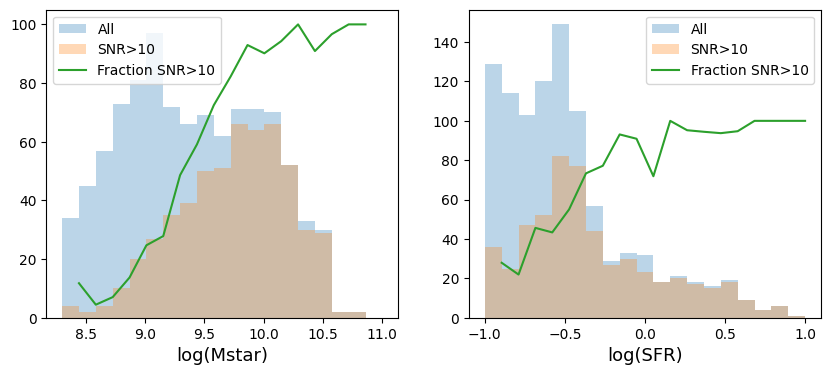

In [307]:
'''
estimate of the fraction of galaxies that make it through to the final sample. 
the mass completeness limit for the sample (>9.3) is very different than for the full sample (>8.26).
'''
nbins=20
mybins=np.linspace(8.3,11,nbins)
mybins_sfr=np.linspace(-1,1,nbins)

plt.subplots(1,2,figsize=(10,4))
plt.subplot(121)
mtot=plt.hist(logmass,bins=mybins,alpha=0.3,label='All')
m15=plt.hist(logmass[snr15_flag | snr30_flag],bins=mybins,alpha=0.3,label='SNR>10')
mratio=m15[0]/mtot[0]
plt.plot(mybins[1:],mratio*100,label='Fraction SNR>10')
plt.legend()
plt.xlabel('log(Mstar)',fontsize=13)


plt.subplot(122)
stot=plt.hist(logsfr,bins=mybins_sfr,alpha=0.3,label='All')
s15=plt.hist(logsfr[snr15_flag | snr30_flag],bins=mybins_sfr,alpha=0.3,label='SNR>10')
sratio=s15[0]/stot[0]
plt.plot(mybins_sfr[1:],sratio*100,label='Fraction SNR>10')
plt.legend()
plt.xlabel('log(SFR)',fontsize=13)
plt.savefig(homedir+'/Desktop/hist.png',dpi=100)
plt.show()

/var/folders/gx/q5wqxlgs0rgfm6f87vgxlgyw4s52w0/T/ipykernel_7312/3271245600.py:6: RuntimeWarning: invalid value encountered in divide
  ratio = counts2 / (counts1)


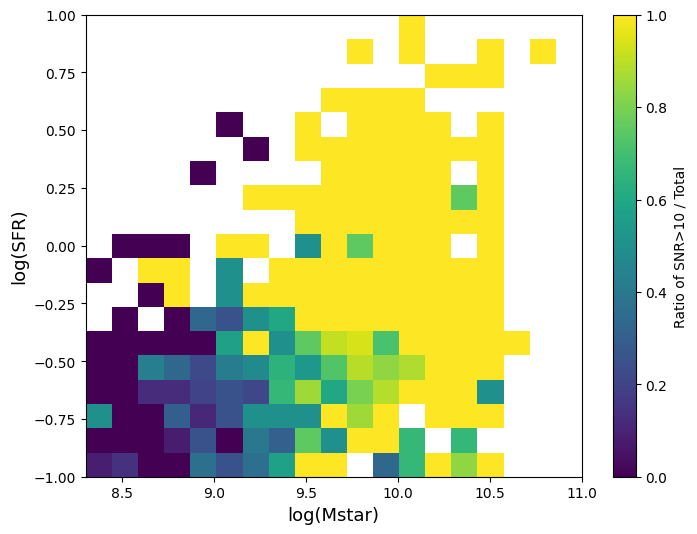

'\nSample completeness in SFR v. stellar mass plot. Need log(Mstar)>9.3 for mass completeness according to sample \n(and NOT the total VFS).\n'

In [325]:
def bin_data(x, y, bins):
    counts, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    return counts, x_edges, y_edges

def calculate_ratio(counts1, counts2):
    ratio = counts2 / (counts1)
    return ratio

def plot_ratio(ratio, x_edges, y_edges):
    plt.figure(figsize=(8, 6))
    plt.imshow(ratio.T, origin='lower', aspect='auto',
               extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
               cmap='viridis')
    plt.colorbar(label='Ratio of SNR>10 / Total')
    plt.xlabel('log(Mstar)',fontsize=13)
    plt.ylabel('log(SFR)',fontsize=13)
    plt.show()
    
nbins = 20
massbins=np.linspace(8.3,11,nbins)
sfrbins=np.linspace(-1.,1.,nbins)
mybins=[massbins,sfrbins]

x2=logmass[snr15_flag | snr30_flag]
y2=logsfr[snr15_flag | snr30_flag]
x1=logmass
y1=logsfr

# Bin the data
counts1, x_edges, y_edges = bin_data(x1, y1, mybins)
counts2, x_edges, y_edges = bin_data(x2, y2, mybins)

# Calculate the ratio
ratio = calculate_ratio(counts1, counts2)

# Plot the resulting ratios
plot_ratio(ratio, x_edges, y_edges)

'''
Sample completeness in SFR v. stellar mass plot. Need log(Mstar)>9.3 for mass completeness according to sample 
(and NOT the total VFS).
'''

(8.0, 11.0)

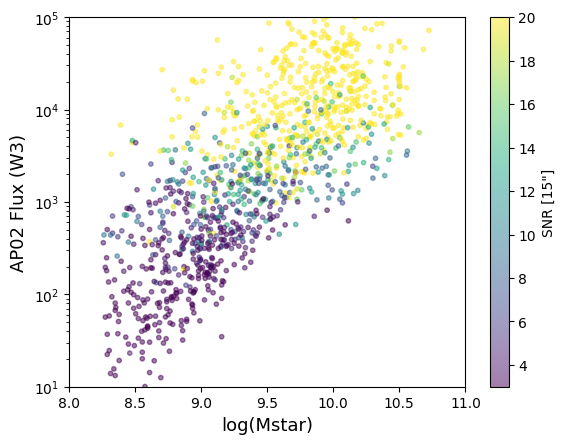

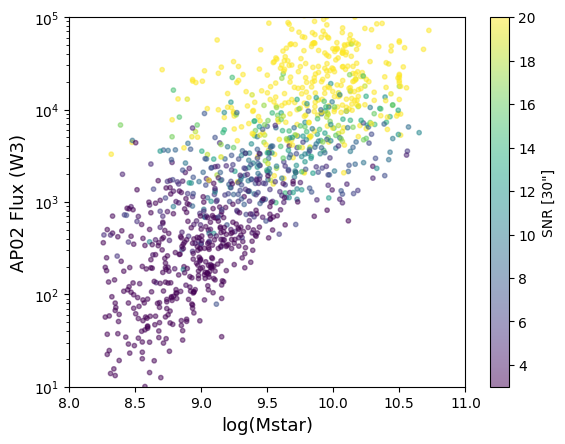

In [243]:
plt.scatter(logmass,x,c=snr15,vmin=3.,vmax=20.,alpha=0.5,s=10)
plt.yscale('log')
plt.colorbar(label='SNR [15"]')
plt.xlabel('log(Mstar)',fontsize=13)
plt.ylabel('AP02 Flux (W3)',fontsize=13)
plt.ylim(10.,1.e5)
plt.xlim(8.,11.)
plt.figure()
plt.scatter(logmass,x,c=snr30,vmin=3.,vmax=20.,alpha=0.5,s=10)
plt.yscale('log')
plt.colorbar(label='SNR [30"]')
plt.xlabel('log(Mstar)',fontsize=13)
plt.ylabel('AP02 Flux (W3)',fontsize=13)
plt.ylim(10.,1.e5)
plt.xlim(8.,11.)

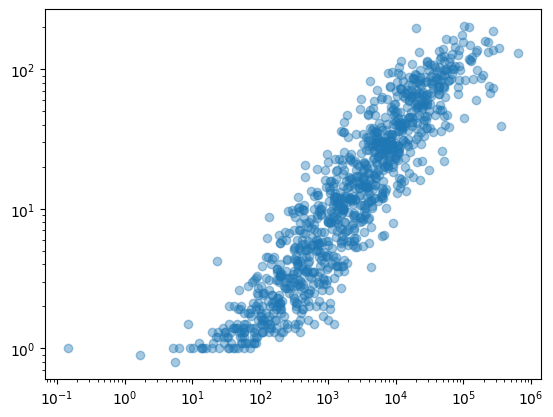

In [309]:
x=phot['FLUX_AP01_W3']
plt.scatter(x,snr15,alpha=0.4)
plt.yscale('log')
plt.xscale('log')
#expect there to be some correlation